<a href="https://colab.research.google.com/github/rahiakela/natural-language-processing-case-studies/blob/master/neural_machine_translation_with_attention_for_english_hindi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural machine translation with attention for English-Hindi


This notebook trains a sequence to sequence (seq2seq) model for Hindi to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Hindi sentence, such as *"तुम कहाँ जा रहे हो?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src='https://github.com/rahiakela/img-repo/blob/master/hin-eng.png?raw=1' width='800' alt='hindi-english attention plot'/>

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Load and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿क्या मैं इस पुस्तक को उधार ले सकता हूँ?
```

There are a variety of languages available, but we'll use the English-Hindi dataset. After loading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

### 0. Load the Hindi - English dataset 

In [166]:
# fetch dataset from github
! git clone https://github.com/rahiakela/machine-learning-datasets -b  hindi-english-encoder-dataset

Cloning into 'machine-learning-datasets'...
remote: Enumerating objects: 2014, done.
remote: Counting objects: 100% (2014/2014), done.
remote: Compressing objects: 100% (2013/2013), done.
remote: Total 2014 (delta 2), reused 2012 (delta 0), pack-reused 0
Receiving objects: 100% (2014/2014), 4.33 MiB | 2.63 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [0]:
# Download the file hin-eng.zip for Hindi - English
import zipfile

with zipfile.ZipFile('machine-learning-datasets/hin-eng.zip', 'r') as zip_ref:
    zip_ref.extractall('hin-eng')
path_to_file = 'hin-eng/hin.txt'

### 1. Add a start and end token to each sentence.

In [121]:
# checking the lower and strip feature
hin_sentence = u'क्या मैं इस पुस्तक को उधार ले सकता हूँ?'
print(hin_sentence.strip())
print(hin_sentence.lower().strip())

क्या मैं इस पुस्तक को उधार ले सकता हूँ?
क्या मैं इस पुस्तक को उधार ले सकता हूँ?


In [122]:
# # Converts the unicode to ascii
print(unicodedata.normalize('NFD', hin_sentence))

क्या मैं इस पुस्तक को उधार ले सकता हूँ?


In [123]:
print([c for c in unicodedata.normalize('NFD', hin_sentence)])

['क', '्', 'य', 'ा', ' ', 'म', 'ै', 'ं', ' ', 'इ', 'स', ' ', 'प', 'ु', 'स', '्', 'त', 'क', ' ', 'क', 'ो', ' ', 'उ', 'ध', 'ा', 'र', ' ', 'ल', 'े', ' ', 'स', 'क', 'त', 'ा', ' ', 'ह', 'ू', 'ँ', '?']


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(sentence, lang='E'):
  if lang != 'H':
    return ''.join(c for c in unicodedata.normalize('NFD', sentence) if unicodedata.category(c) != 'Mn')
  else:
    return ''.join(c for c in unicodedata.normalize('NFD', sentence))

def preprocess_sentence(sent, lang='E'):
  sent = unicode_to_ascii(sent.lower().strip(), lang)
  
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  sent = re.sub(r'([?.!,¿])', r' \1 ', sent)
  
  sent = re.sub(r'[" "]+', " ", sent)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  if lang != 'H':
    sent = re.sub(r'[^a-zA-Z?.!,¿]+', ' ', sent)

  sent = sent.rstrip().strip()

  # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
  sent = '<start> ' + sent + ' <end>'

  return sent

In [125]:
en_sentence = u'May I borrow this book?'
hin_sentence = u'क्या मैं इस पुस्तक को उधार ले सकता हूँ?'

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(hin_sentence, lang='H'))

<start> may i borrow this book ? <end>
<start> क्या मैं इस पुस्तक को उधार ले सकता हूँ ? <end>


### 2. Clean the sentences by removing special characters.

We will do the following things in this section:

1. Remove the accents
2. Clean the sentences
3. Return word pairs in the format: [ENGLISH, HINDI]

In [126]:
# check for each line
lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')
lines[:5]

['Wow!\tवाह!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)',
 'Help!\tबचाओ!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #459377 (minshirui)',
 'Jump.\tउछलो.\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179121 (fastrizwaan)',
 'Jump.\tकूदो.\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179122 (fastrizwaan)',
 'Jump.\tछलांग.\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179123 (fastrizwaan)']

In [127]:
# extracting word from each line
word_pairs = [[word for word in line.split('\t')] for line in lines[:]]
word_pairs[:5]

[['Wow!',
  'वाह!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)'],
 ['Help!',
  'बचाओ!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #459377 (minshirui)'],
 ['Jump.',
  'उछलो.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179121 (fastrizwaan)'],
 ['Jump.',
  'कूदो.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179122 (fastrizwaan)'],
 ['Jump.',
  'छलांग.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179123 (fastrizwaan)']]

In [128]:
# extracting word from each line except last one
word_pairs = [[word for word in line.split('\t')[:-1]] for line in lines[:]]
word_pairs[:5]

[['Wow!', 'वाह!'],
 ['Help!', 'बचाओ!'],
 ['Jump.', 'उछलो.'],
 ['Jump.', 'कूदो.'],
 ['Jump.', 'छलांग.']]

In [0]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(word, lang='H') for word in line.split('\t')[:-1]] for line in lines[: num_examples]]

  return zip(*word_pairs)

In [0]:
en_sent, hin_sent = create_dataset(path_to_file, None)

In [131]:
# check last sentence
print(en_sent[-1])
print(hin_sent[-1])

<start> when i was a kid , touching bugs didn't bother me a bit . now i can hardly stand looking at pictures of them . <end>
<start> जब मैं बच्चा था , मुझे कीड़ों को छूने से कोई परेशानी नहीं होती थी , पर अब मैं उनकी तस्वीरें देखना भी बर्दाश्त नहीं कर सकता। <end>


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  target_lang, input_lang = create_dataset(path, num_examples)

  input_tensor, input_lang_tokenizer = tokenize(input_lang)
  target_tensor, target_lang_tokenizer = tokenize(target_lang)

  return input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset will take a long time. To train faster, we can limit the size of the dataset to the specified sentences (of course, translation quality degrades with less data) but here we will train on whole dataset:

In [135]:
# Try experimenting with the size of that dataset
num_examples = None
input_tensor, target_tensor, input_lang, target_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_target, max_length_input = max_length(target_tensor), max_length(input_tensor)
print(max_length_target, max_length_input)

27 29


In [136]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,
                                                                                                target_tensor,
                                                                                                test_size=0.2)
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

2223 2223 556 556


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print('%d ----> %s' % (t, lang.index_word[t]))

In [138]:
print('Input Language; index to word mapping')
convert(input_lang, input_tensor_train[0])
print()
print('Target Language; index to word mapping')
convert(target_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
279 ----> पिछले
2295 ----> शनिवार
9 ----> से
184 ----> मौसम
18 ----> बहुत
82 ----> अच्छा
3 ----> है।
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
14 ----> it
45 ----> has
68 ----> been
901 ----> fine
393 ----> since
119 ----> last
1144 ----> friday
3 ----> .
2 ----> <end>


In [139]:
print('Input Language; index to word mapping')
convert(input_lang, input_tensor_train[1])
print()
print('Target Language; index to word mapping')
convert(target_lang, target_tensor_train[1])

Input Language; index to word mapping
1 ----> <start>
137 ----> अगर
367 ----> कॉफ़ी
115 ----> ज़्यादा
2776 ----> कड़वी
13 ----> है
42 ----> तो
209 ----> थोड़ा
32 ----> और
189 ----> पानी
2777 ----> डाललो।
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
77 ----> if
4 ----> the
306 ----> coffee
9 ----> is
110 ----> too
556 ----> strong
20 ----> ,
779 ----> add
130 ----> some
127 ----> more
166 ----> water
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_input_size = len(input_lang.word_index) + 1
vocab_target_size = len(target_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [141]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 29]), TensorShape([64, 27]))

In [142]:
print(example_input_batch.shape, example_target_batch.shape)

(64, 29) (64, 27)


## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src='https://github.com/rahiakela/img-repo/blob/master/attention.jpg?raw=1' width='800' alt='hindi-english attention plot'/>

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [0]:
class Encoder(tf.keras.Model):

  def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.encoder_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.encoder_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
  def call(self, x, hidden):
    x = self.embedding(x)
    encoder_output, hidden_state = self.gru(x, initial_state=hidden)
    return encoder_output, hidden_state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.encoder_units))

In [144]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print(f'Encoder output shape: (batch size, sequence length, units) {sample_output.shape}')
print(f'Encoder Hidden state shape: (batch size, units) {sample_hidden.shape}')

Encoder output shape: (batch size, sequence length, units) (64, 29, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):

  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = tf.reduce_sum(attention_weights * values, axis=1)

    return context_vector, attention_weights

In [146]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print(f'Attention result shape: (batch size, units) {attention_result.shape}')
print(f'Attention weights shape: (batch_size, sequence_length, 1) {attention_weights.shape}')

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 29, 1)


In [0]:
class Decoder(tf.keras.Model):

  def __init__(self, vocab_size, embedding_dim, decoder_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.decoder_units = decoder_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.decoder_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.decoder_units)

  def call(self, x, hidden, encoder_output):
    # encoder_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, encoder_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [148]:
decoder = Decoder(vocab_target_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print(f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (64, 2389)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inputs, targets, encoder_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    encoder_output, encoder_hidden = encoder(inputs, encoder_hidden)
    decoder_hidden = encoder_hidden
    decoder_input = tf.expand_dims([target_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targets.shape[1]):
      # passing encoder_output to the decoder
      predictions, encoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output)
      loss += loss_function(targets[:, t], predictions)

      # using teacher forcing
      decoder_input = tf.expand_dims(targets[:, t], 1)
  batch_loss = (loss / int(targets.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [152]:
EPOCHS = 100

epoch_list = []
loss_list = []
for epoch in range(EPOCHS):
  start = time.time()
  encoder_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inputs, targets)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inputs, targets, encoder_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {str(epoch + 1)} Batch {str(batch)} Loss {str(batch_loss.numpy())}')
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  epochs = epoch + 1
  losses = total_loss / steps_per_epoch

  # storing for ploting
  epoch_list.append(epochs)
  loss_list.append(losses)

  print('Epoch {} Loss {:.4f}'.format(epochs, losses))
  print(f'Time taken for 1 epoch {str(time.time() - start)} sec\n')

Epoch 1 Batch 0 Loss 2.3902936
Epoch 1 Loss 1.8316
Time taken for 1 epoch 30.937663555145264 sec

Epoch 2 Batch 0 Loss 1.5205787
Epoch 2 Loss 1.5238
Time taken for 1 epoch 7.382741212844849 sec

Epoch 3 Batch 0 Loss 1.4703759
Epoch 3 Loss 1.4191
Time taken for 1 epoch 6.93349814414978 sec

Epoch 4 Batch 0 Loss 1.35262
Epoch 4 Loss 1.3360
Time taken for 1 epoch 7.384093523025513 sec

Epoch 5 Batch 0 Loss 1.2810243
Epoch 5 Loss 1.2540
Time taken for 1 epoch 7.022329568862915 sec

Epoch 6 Batch 0 Loss 1.2587395
Epoch 6 Loss 1.1790
Time taken for 1 epoch 7.4676148891448975 sec

Epoch 7 Batch 0 Loss 1.1802473
Epoch 7 Loss 1.1142
Time taken for 1 epoch 7.052628755569458 sec

Epoch 8 Batch 0 Loss 1.1046743
Epoch 8 Loss 1.0524
Time taken for 1 epoch 7.4993815422058105 sec

Epoch 9 Batch 0 Loss 0.950053
Epoch 9 Loss 0.9946
Time taken for 1 epoch 7.0900256633758545 sec

Epoch 10 Batch 0 Loss 0.9290471
Epoch 10 Loss 0.9468
Time taken for 1 epoch 7.494141578674316 sec

Epoch 11 Batch 0 Loss 0.8244

In [153]:
print(len(epoch_list))
print(len(loss_list))

100
100


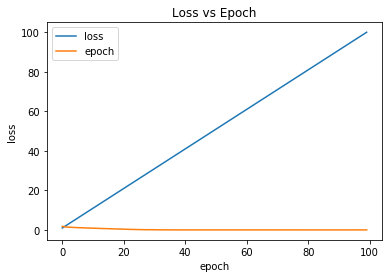

In [165]:
# summarize loss
plt.plot(epoch_list)
plt.plot(loss_list)
plt.title('Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'epoch'], loc='upper left')
plt.show()

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_target, max_length_input))
  sentence = preprocess_sentence(sentence, lang='H')

  inputs = [input_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_input, padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  encoder_output, encoder_hidden = encoder(inputs, hidden)

  decoder_hidden = encoder_hidden
  decoder_input = tf.expand_dims([target_lang.word_index['<start>']], 0)

  for t in range(max_length_target):
    predictions, decoder_hidden, attention_weights = decoder(decoder_input, decoder_hidden, encoder_output)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()
    result += target_lang.index_word[predicted_id] + ' '

    if target_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    decoder_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
from matplotlib.font_manager import FontProperties

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}
  hindi_font = FontProperties(fname = 'machine-learning-datasets/nirmala.ttf')

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, fontproperties=hindi_font, color='b')
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [158]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> मैं खेल रहा था। <end>
Predicted translation: i was a taxi . <end> 


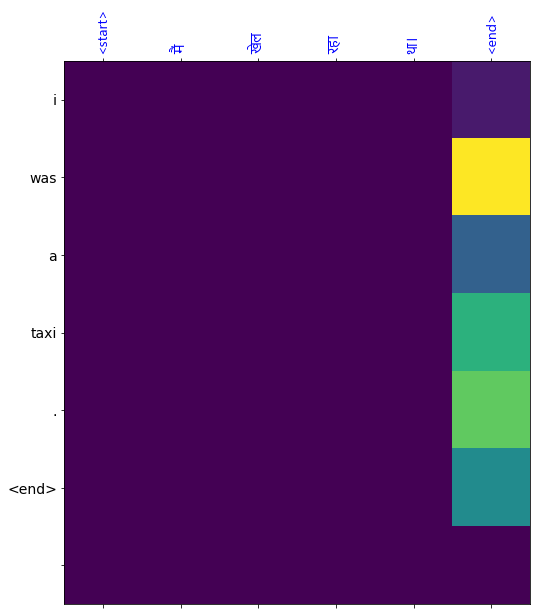

In [159]:
translate(u'मैं खेल रहा था।')

Input: <start> मैं दस बजे वापस आऊँगा। <end>
Predicted translation: i'll come back . <end> 


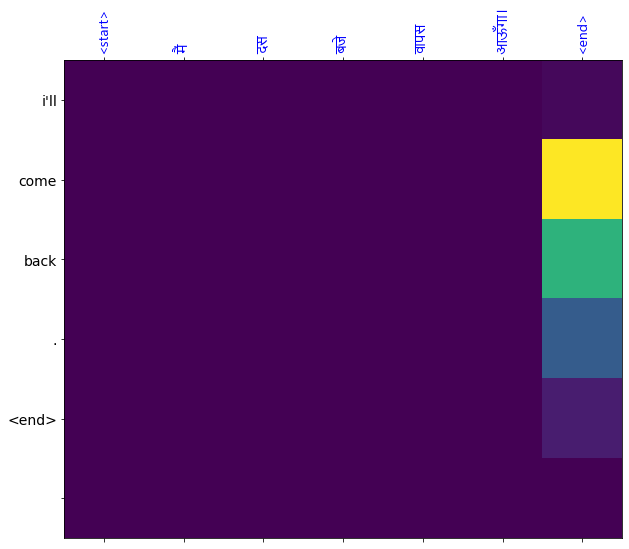

In [160]:
translate(u'मैं दस बजे वापस आऊँगा।')

Input: <start> मैं शराब लाता हूँ। <end>
Predicted translation: i'll bring the wine . <end> 


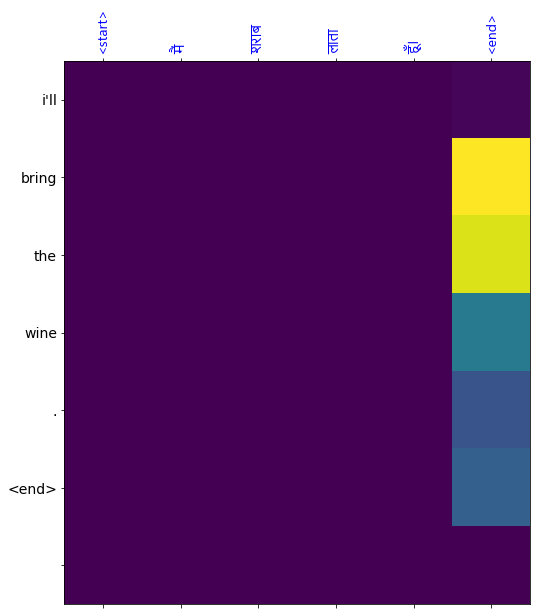

In [161]:
translate(u'मैं शराब लाता हूँ।')

Input: <start> तुमने क्या जवाब दिया ? <end>
Predicted translation: will you please explain it ? <end> 


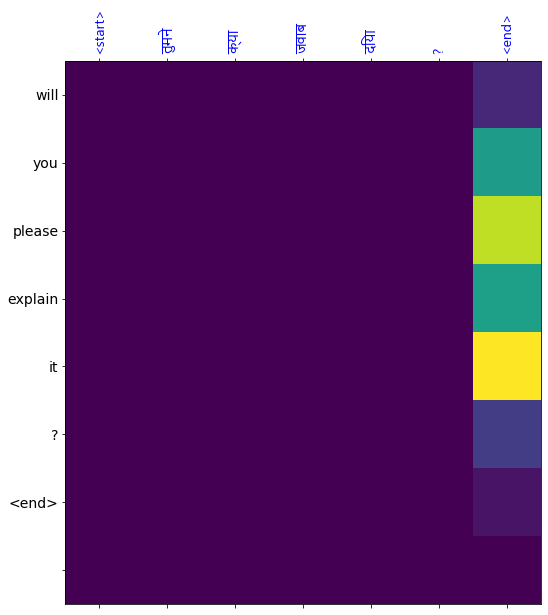

In [162]:
# wrong translation
translate(u'तुमने क्या जवाब दिया?')

Input: <start> इस डब्बे में क्या है ? <end>
Predicted translation: what is in this box ? <end> 


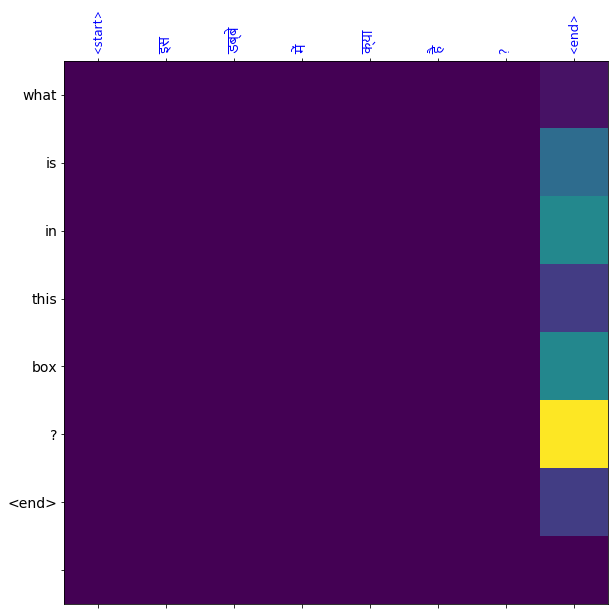

In [163]:
translate(u'इस डब्बे में क्या है?')

Input: <start> तुम हमारे साथ आओगे क्या ? <end>
Predicted translation: will you go with us ? <end> 


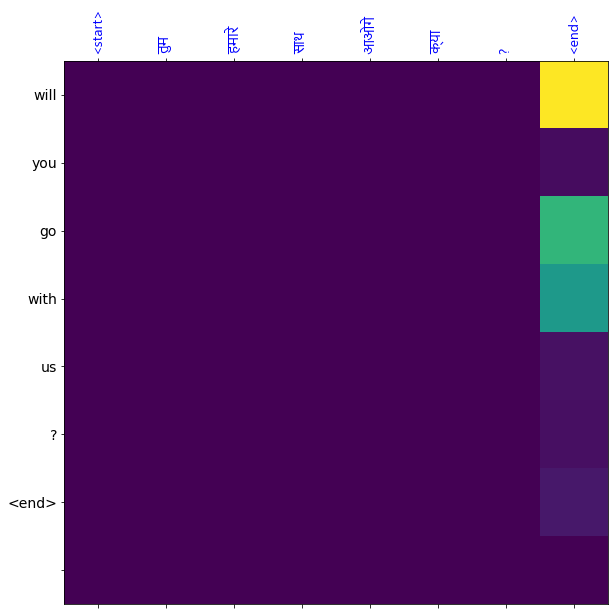

In [164]:
translate(u'तुम हमारे साथ आओगे क्या?')

## Next steps


* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs